# Image Classification

In [ ]:
# --- Imports from all files ---
import torch
from torch import nn
import torchvision
from torchvision import models, datasets, transforms
import timm
import kornia
from kornia.losses import FocalLoss

import yaml
import logging
from datetime import datetime
from pathlib import Path
import time
import pickle
import os
import inspect
import argparse # For running predict/explain

# Math, CV, and Plotting
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# DataLoading
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

# TQDM
from tqdm.auto import tqdm # .auto works in both console and notebook

# Metrics and XAI
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

# Typing
from typing import Sequence, Optional, Dict, Any, List, Callable, Tuple

In [ ]:
# Contents of config_cv.yaml, loaded as a Python dict
cfg = {
    'data': {
        'train_dir': 'clean/train',
        'val_dir': 'clean/val',
        'test_dir': 'clean/test',
        'test_split_ratio': 0.2
    },
    'model_params': {
        'name': 'efficientnet_b0',
        'pretrained': True,
        'local_weights_dir': 'pretrained_models'
    },
    'loss_function': {
        'name': 'CrossEntropyLoss',
        'params': {
            'alpha': 0.25,
            'gamma': 2.0,
            'reduction': 'mean'
        }
    },
    'data_params': {
        'image_size': 224,
        'batch_size': 32,
        'num_workers': 0
    },
    'train_params': {
        'epochs': 5,
        'finetune_epochs': 3,
        'learning_rate': 0.001,
        'finetune_learning_rate': 5e-05,
        'optimizer': 'AdamW',
        'scheduler': {
            'name': 'None',
            'params': {
                'T_max': 10
            }
        }
    },
    'outputs': {
        'base_dir': 'outputs',
        'log_file': '{run_folder}/run.log',
        'model_path': '{run_folder}/best_model.pth',
        'report_path': '{run_folder}/results_report.pkl',
        'cm_plot_path': '{run_folder}/confusion_matrix.png',
        'submission_file': '{run_folder}/submission.csv',
        'training_curves_plot_path': '{run_folder}/training_curves.png',
        'model_path_finetuned': '{run_folder}/best_model_finetuned.pth',
        'report_path_finetuned': '{run_folder}/results_report_finetuned.pkl',
        'cm_plot_path_finetuned': '{run_folder}/confusion_matrix_finetuned.png',
        'training_curves_plot_path_finetuned': '{run_folder}/training_curves_finetuned.png'
    }
}

print(f"Config loaded. Model to run: {cfg['model_params']['name']}")

Config loaded. Model to run: efficientnet_b0


In [ ]:
# Contents of config_aug_fix.py
AUGMENTATION_CONFIG = {
    "data": {
        "image_size": 224,
        "normalize": {
            "mean": [0.485, 0.456, 0.406],
            "std":  [0.229, 0.224, 0.225]
        },
        "batch_size": 32,
        "num_workers": 0,
        "pin_memory": True
    },
    "train": {
        # geometric
        "random_resized_crop": { "enabled": True,  "size": 224, "scale": [0.85, 1.0], "ratio": [0.75, 1.33] },
        "resize":              { "enabled": False, "size": None },
        "horizontal_flip":     { "enabled": True,  "p": 0.5 },
        "vertical_flip":       { "enabled": False, "p": 0.0 },
        "rotation":            { "enabled": True, "degrees": 15 },
        "affine":              { "enabled": False, "translate": 0.10, "scale": [0.9, 1.1], "shear": 15, "degrees": 0 },

        # photometric (new + old)
        "color_jitter":        { "enabled": False, "brightness": 0.15, "contrast": 0.15, "saturation": 0.15, "hue": 0.02 },
        "brightness_contrast": { "enabled": False, "brightness_limit": 0.15, "contrast_limit": 0.15 },
        "blur":                { "enabled": False, "blur_limit": 3 },
        "gaussian_noise":      { "enabled": False, "var_limit": [10.0, 50.0] },
        "sharpen":             { "enabled": False, "alpha": [0.2, 0.5], "lightness": [0.5, 1.0] },
        "jpeg":                { "enabled": False, "quality_lower": 80, "quality_upper": 100 },
        "grayscale":           { "enabled": False },

        # NEW: parity with aug_detection_fix extras
        "clahe":               { "enabled": False, "clip_limit": 4.0, "tile_grid_size": [8, 8], "p": 0.5 },
        "ahe":                 { "enabled": False, "clip_limit": 4.0, "tile_grid_size": [8, 8], "p": 0.5 },
        "equalize":            { "enabled": False, "mode": "cv", "by_channels": True, "p": 0.5 },
        "denoise":             { "enabled": False, "h": 10, "hColor": 10, "templateWindowSize": 7, "searchWindowSize": 21, "p": 0.5 },
        "defog":               { "enabled": False, "omega": 0.95, "t0": 0.1, "radius": 7, "p": 0.5 }
    },
    "test": {
        "resize":       { "enabled": True,  "size": None },
        "center_crop":  { "enabled": False, "size": None }
    }
}


In [ ]:
# Contents of model_definitions.py

# This dictionary is now the single source of truth for all models.
# It maps the model's string name to its creation function.
AVAILABLE_MODELS = {
    "efficientnet_b0": models.efficientnet_b0,
    "resnet18": models.resnet18,
    "resnet50": models.resnet50,
    "vit_b_16": models.vit_b_16,
    "convnext_tiny": models.convnext_tiny,
    "swin_t": models.swin_t,
    "maxvit_tiny": lambda weights: timm.create_model('maxvit_tiny_tf_224', pretrained=True if weights else False),
    "cvt_13": lambda weights: timm.create_model('cvt_13_224', pretrained=True if weights else False),
    "coat_lite_mini": lambda weights: timm.create_model('coat_lite_mini', pretrained=True if weights else False),
    "efficientformerv2_s0": lambda weights: timm.create_model('efficientformerv2_s0', pretrained=True if weights else False),
    "levit_192": lambda weights: timm.create_model('levit_192', pretrained=True if weights else False),
}

In [ ]:
# Notebook-friendly version of set_model.py

MODEL_NAMES = list(AVAILABLE_MODELS.keys())

def set_active_model_notebook(): 
    """
    Displays a menu and updates the global `cfg` dictionary in memory.
    """
    global cfg # Ensure we are modifying the main config object
    
    print("Please select the model you want to use for the next run:")
    for i, model_name in enumerate(MODEL_NAMES, 1):
        print(f"  [{i}] {model_name}")

    # Get user input
    while True:
        try:
            choice = int(input("\nEnter the number of your choice: "))
            if 1 <= choice <= len(MODEL_NAMES):
                selected_model = MODEL_NAMES[choice - 1]
                break
            else:
                print(f"Invalid choice. Please enter a number between 1 and {len(MODEL_NAMES)}.")
        except ValueError:
            print("Invalid input. Please enter a number.")

    # Update the in-memory config dictionary
    cfg['model_params']['name'] = selected_model
    print(f"\n✅ Success! The notebook's config has been updated to use: {selected_model}")
    print("   Run the 'Download Models' cell, then the 'Run Training Pipeline' cell.")

# --- Run this cell to change your model ---
set_active_model_notebook()

Please select the model you want to use for the next run:
  [1] efficientnet_b0
  [2] resnet18
  [3] resnet50
  [4] vit_b_16
  [5] convnext_tiny
  [6] swin_t
  [7] maxvit_tiny
  [8] cvt_13
  [9] coat_lite_mini
  [10] efficientformerv2_s0
  [11] levit_192

✅ Success! The notebook's config has been updated to use: efficientnet_b0
   Run the 'Download Models' cell, then the 'Run Training Pipeline' cell.


In [6]:
# Contents of download_model.py
# (Imports are already in Cell 1)
# (AVAILABLE_MODELS is in Cell 5)

def save_model(model_name, save_dir="pretrained_models"):
    """Downloads a model and saves its state_dict to a local directory."""
    if model_name not in AVAILABLE_MODELS:
        print(f"Error: Model '{model_name}' is not available. Choose from: {list(AVAILABLE_MODELS.keys())}")
        return

    # Create the save directory if it doesn't exist
    save_path = Path(save_dir)
    save_path.mkdir(parents=True, exist_ok=True)
    
    # Define the output file path
    output_file = save_path / f"{model_name}.pth"
    
    if output_file.exists():
        print(f"Model '{model_name}' already exists at {output_file}. Skipping download.")
        return

    print(f"\nDownloading {model_name}...")
    try:
        # Load the model with pre-trained weights (this triggers the download to cache)
        model = AVAILABLE_MODELS[model_name](weights='DEFAULT')
        
        # Save the model's state dictionary to your specified path
        torch.save(model.state_dict(), output_file)
        
        print(f" -> Successfully saved '{model_name}' to {output_file}")
    except Exception as e:
        print(f" -> Failed to download or save {model_name}. Error: {e}")

In [7]:
# Get the model name from our main config
model_to_download = cfg['model_params']['name']

# Run the downloader
save_model(model_to_download)

# Or, download all of them
# for model_name in AVAILABLE_MODELS:
#     save_model(model_name)

Model 'efficientnet_b0' already exists at pretrained_models\efficientnet_b0.pth. Skipping download.


In [8]:
# Contents of utils.py

def save_model(model: torch.nn.Module, target_path: str):
    """Saves a PyTorch model state_dict to a target directory."""
    target_path = Path(target_path)
    target_path.parent.mkdir(parents=True, exist_ok=True)
    try:
        torch.save(obj=model.state_dict(), f=target_path)
        logging.info(f"Model saved to {target_path}")
    except Exception as e:
        logging.error(f"Error saving model to {target_path}: {e}")

def save_report(report_dict, target_path):
    """Saves a Python dictionary (e.g., training results) to a pickle file."""
    target_path = Path(target_path)
    target_path.parent.mkdir(parents=True, exist_ok=True)
    try:
        with open(target_path, 'wb') as f:
            pickle.dump(report_dict, f)
        logging.info(f"Report saved to {target_path}")
    except Exception as e:
        logging.error(f"Error saving report to {target_path}: {e}")

def plot_and_save_curves(results, save_path):
    """
    Plots the training and validation accuracy/loss curves and saves the figure.
    """
    try:
        epochs = range(len(results["train_loss"]))

        plt.figure(figsize=(12, 5))

        # Plot Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(epochs, results["train_acc"], label="Train Accuracy")
        plt.plot(epochs, results["test_acc"], label="Validation Accuracy")
        plt.title("Accuracy Curve")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)

        # Plot Loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs, results["train_loss"], label="Train Loss")
        plt.plot(epochs, results["test_loss"], label="Validation Loss")
        plt.title("Loss Curve")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close() # Close the plot to free up memory
        logging.info(f"Training curves plot saved to: {save_path}")

    except Exception as e:
        logging.error(f"Could not create training curves plot: {e}")

In [9]:
# Contents of aug_albumentation_2.py

# ---------------- utils ----------------

def _to_hw(size: Optional[Sequence[int] | int]):
    if size is None:
        return None
    if isinstance(size, int):
        return (size, size)
    if isinstance(size, (list, tuple)) and len(size) == 2:
        return (int(size[0]), int(size[1]))
    raise ValueError("image_size must be int or [H, W]")

def _supports_size_kw(transform_cls):
    """Compat helper for different Albumentations versions (height/width vs size kw)."""
    try:
        sig = inspect.signature(transform_cls.__init__)
    except (TypeError, ValueError):
        return False
    return any(p.name == "size" for p in sig.parameters.values())

def _make_random_resized_crop(h: int, w: int, scale, ratio, p: float):
    if _supports_size_kw(A.RandomResizedCrop):
        return A.RandomResizedCrop(size=(h, w), scale=scale, ratio=ratio, p=p)
    return A.RandomResizedCrop(height=h, width=w, scale=scale, ratio=ratio, p=p)

def _make_resize(h: int, w: int, interpolation=cv2.INTER_AREA):
    if _supports_size_kw(A.Resize):
        return A.Resize(size=(h, w), interpolation=interpolation)
    return A.Resize(height=h, width=w, interpolation=interpolation)

def _make_center_crop(h: int, w: int):
    if _supports_size_kw(A.CenterCrop):
        return A.CenterCrop(size=(h, w))
    return A.CenterCrop(height=h, width=w)

# ---------------- custom transforms (optional extras) ----------------

from albumentations.core.transforms_interface import ImageOnlyTransform

class AHETransform(ImageOnlyTransform):
    def __init__(self, tile_grid_size=(8,8), clip_limit=4.0, always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.tile_grid_size = tuple(tile_grid_size)
        self.clip_limit = float(clip_limit)

    def apply(self, img, **params):
        img = img.copy()
        if img.ndim == 2:
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            return clahe.apply(img)
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv)
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        v = clahe.apply(v)
        hsv = cv2.merge([h, s, v])
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

class DehazeSimple(ImageOnlyTransform):
    def __init__(self, omega=0.95, t0=0.1, radius=7, always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.omega = float(omega)
        self.t0 = float(t0)
        self.radius = int(radius)

    def _dark_channel(self, img, radius):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (radius, radius))
        min_per_channel = img.min(axis=2)
        dark = cv2.erode(min_per_channel, kernel)
        return dark

    def apply(self, img, **params):
        I = img.astype(np.float32) / 255.0
        dark = self._dark_channel(I, self.radius)
        flat = dark.reshape(-1)
        topk = max(1, int(flat.size * 0.001))
        idx = np.argpartition(flat, -topk)[-topk:]
        A_atm = I.reshape(-1, 3)[idx].mean(axis=0)
        norm_I = I / (A_atm.reshape(1,1,3) + 1e-6)
        t = 1.0 - self.omega * self._dark_channel(norm_I, self.radius)
        t = np.clip(t, self.t0, 1.0)
        J = (I - A_atm.reshape(1,1,3)) / t[..., None] + A_atm.reshape(1,1,3)
        J = np.clip(J * 255.0, 0, 255).astype(np.uint8)
        return J

# ---------------- pickle-safe wrapper ----------------

class ComposeCallable:
    """Top-level callable wrapper so DataLoader workers (spawn) can pickle it on Windows."""
    def __init__(self, compose: A.Compose):
        self.compose = compose

    def __call__(self, img):
        # Convert incoming image to RGB numpy
        if hasattr(img, "mode"):  # PIL.Image
            img = np.array(img.convert("RGB"))
        else:
            img = np.asarray(img)
            if img.ndim == 2:
                img = np.stack([img]*3, axis=-1)
            elif img.ndim == 3 and img.shape[2] == 4:  # RGBA -> RGB
                img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
        out = self.compose(image=img)
        tensor: torch.Tensor = out["image"]
        return tensor

# ---------------- internal helpers ----------------

def _add_if_enabled(t_list: List[A.BasicTransform], name: str, cfg: Dict[str, Any]):
    if not cfg or not cfg.get("enabled", False):
        return
    p = float(cfg.get("p", 0.5))

    if name == "random_resized_crop":
        scale = tuple(cfg.get("scale", (0.85, 1.0)))
        ratio = tuple(cfg.get("ratio", (0.75, 1.33)))
        size = cfg.get("size")
        if size is None:
            raise ValueError("random_resized_crop requires 'size' in config (int or [H, W])")
        h, w = _to_hw(size)
        t_list.append(_make_random_resized_crop(h, w, scale=scale, ratio=ratio, p=1.0))
        return

    if name == "resize":
        size = cfg.get("size")
        if size is None:
            return
        h, w = _to_hw(size)
        t_list.append(_make_resize(h, w, interpolation=cv2.INTER_AREA))
        return

    if name == "horizontal_flip":
        t_list.append(A.HorizontalFlip(p=p))
    elif name == "vertical_flip":
        t_list.append(A.VerticalFlip(p=p))
    elif name == "rotation":
        t_list.append(A.Rotate(limit=cfg.get("degrees", 15), border_mode=cv2.BORDER_REFLECT_101, p=p))
    elif name == "affine":
        t_list.append(A.Affine(
            scale=tuple(cfg.get("scale", (1.0, 1.0))),
            translate_percent=(cfg.get("translate", 0.0), cfg.get("translate", 0.0)),
            rotate=cfg.get("degrees", 0),
            shear=cfg.get("shear", 0),
            fit_output=False, mode=cv2.BORDER_REFLECT_101, p=p
        ))
    elif name == "color_jitter":
        t_list.append(A.ColorJitter(
            brightness=cfg.get("brightness", 0.15),
            contrast=cfg.get("contrast", 0.15),
            saturation=cfg.get("saturation", 0.15),
            hue=cfg.get("hue", 0.02),
            p=p
        ))
    elif name == "brightness_contrast":
        t_list.append(A.RandomBrightnessContrast(
            brightness_limit=cfg.get("brightness_limit", 0.15),
            contrast_limit=cfg.get("contrast_limit", 0.15),
            p=p
        ))
    elif name == "blur":
        t_list.append(A.Blur(blur_limit=cfg.get("blur_limit", 3), p=p))
    elif name == "gaussian_noise":
        t_list.append(A.GaussNoise(var_limit=tuple(cfg.get("var_limit", (10.0, 50.0))), p=p))
    elif name == "sharpen":
        t_list.append(A.Sharpen(alpha=tuple(cfg.get("alpha", (0.2, 0.5))), lightness=tuple(cfg.get("lightness", (0.5, 1.0))), p=p))
    elif name == "jpeg":
        t_list.append(A.ImageCompression(quality_lower=cfg.get("quality_lower", 80), quality_upper=cfg.get("quality_upper", 100), p=p))
    elif name == "grayscale":
        t_list.append(A.ToGray(p=p))
    elif name == "clahe":
        t_list.append(A.CLAHE(clip_limit=cfg.get("clip_limit", 4.0),
                              tile_grid_size=tuple(cfg.get("tile_grid_size", (8, 8))),
                              p=p))
    elif name == "ahe":
        t_list.append(AHETransform(tile_grid_size=tuple(cfg.get("tile_grid_size", (8, 8))),
                                   clip_limit=cfg.get("clip_limit", 8.0),
                                   p=p))
    elif name == "equalize":
        t_list.append(A.Equalize(mode=cfg.get("mode", "cv"),
                                 by_channels=cfg.get("by_channels", True),
                                 p=p))
    elif name == "denoise":
        t_list.append(A.Denoise(h=cfg.get("h", 10),
                                hColor=cfg.get("hColor", 10),
                                templateWindowSize=cfg.get("templateWindowSize", 7),
                                searchWindowSize=cfg.get("searchWindowSize", 21),
                                p=p))
    elif name == "defog":
        t_list.append(DehazeSimple(omega=float(cfg.get("omega", 0.95)),
                                   t0=float(cfg.get("t0", 0.1)),
                                   radius=int(cfg.get("radius", 7)),
                                   p=p))

# ---------------- public builder ----------------

def build_transforms(cfg, build_train: bool = True, build_test: bool = True):
    """Return (train_transform, test_transform) callables producing normalized tensors.

    This mirrors the signature/behavior of the torchvision-based module so it can be
    swapped without touching the rest of the pipeline.
    """
    data_cfg  = cfg.get("data", {})
    train_cfg = cfg.get("train", {})
    test_cfg  = cfg.get("test",  {})

    image_size = data_cfg.get("image_size", 384)
    im_hw = _to_hw(image_size)
    mean = data_cfg.get("normalize", {}).get("mean", [0.485, 0.456, 0.406])
    std  = data_cfg.get("normalize", {}).get("std",  [0.229, 0.224, 0.225])

    train_transform = None
    test_transform  = None

    # ---------- TRAIN ----------
    if build_train:
        t_list: List[A.BasicTransform] = []

        rr_cfg = train_cfg.get("random_resized_crop", {})
        if rr_cfg.get("enabled", False):
            size = rr_cfg.get("size") or im_hw or (image_size, image_size)
            rr_cfg_local = dict(rr_cfg)
            rr_cfg_local["size"] = size
            _add_if_enabled(t_list, "random_resized_crop", rr_cfg_local)
        else:
            rz_cfg = train_cfg.get("resize", {})
            if rz_cfg.get("enabled", False):
                size = rz_cfg.get("size") or im_hw or (image_size, image_size)
                _add_if_enabled(t_list, "resize", {"enabled": True, "size": size})

        # Geometric
        if train_cfg.get("horizontal_flip", {}).get("enabled", False):
            _add_if_enabled(t_list, "horizontal_flip", train_cfg["horizontal_flip"])
        if train_cfg.get("vertical_flip", {}).get("enabled", False):
            _add_if_enabled(t_list, "vertical_flip", train_cfg["vertical_flip"])
        if train_cfg.get("rotation", {}).get("enabled", False):
            _add_if_enabled(t_list, "rotation", train_cfg["rotation"])
        if train_cfg.get("affine", {}).get("enabled", False):
            _add_if_enabled(t_list, "affine", train_cfg["affine"])

        # Photometric
        if train_cfg.get("color_jitter", {}).get("enabled", False):
            _add_if_enabled(t_list, "color_jitter", train_cfg["color_jitter"])
        if train_cfg.get("brightness_contrast", {}).get("enabled", False):
            _add_if_enabled(t_list, "brightness_contrast", train_cfg["brightness_contrast"])
        if train_cfg.get("blur", {}).get("enabled", False):
            _add_if_enabled(t_list, "blur", train_cfg["blur"])
        if train_cfg.get("gaussian_noise", {}).get("enabled", False):
            _add_if_enabled(t_list, "gaussian_noise", train_cfg["gaussian_noise"])
        if train_cfg.get("sharpen", {}).get("enabled", False):
            _add_if_enabled(t_list, "sharpen", train_cfg["sharpen"])
        if train_cfg.get("jpeg", {}).get("enabled", False):
            _add_if_enabled(t_list, "jpeg", train_cfg["jpeg"])
        if train_cfg.get("grayscale", {}).get("enabled", False):
            _add_if_enabled(t_list, "grayscale", train_cfg["grayscale"])
        if train_cfg.get("clahe", {}).get("enabled", False):
            _add_if_enabled(t_list, "clahe", train_cfg["clahe"])
        if train_cfg.get("ahe", {}).get("enabled", False):
            _add_if_enabled(t_list, "ahe", train_cfg["ahe"])
        if train_cfg.get("equalize", {}).get("enabled", False):
            _add_if_enabled(t_list, "equalize", train_cfg["equalize"])
        if train_cfg.get("denoise", {}).get("enabled", False):
            _add_if_enabled(t_list, "denoise", train_cfg["denoise"])
        if train_cfg.get("defog", {}).get("enabled", False):
            _add_if_enabled(t_list, "defog", train_cfg["defog"])

        # Normalize + to tensor at the end
        t_list.extend([A.Normalize(mean=mean, std=std), ToTensorV2()])
        train_transform = ComposeCallable(A.Compose(t_list))

    # ---------- TEST/VALID ----------
    if build_test:
        tt: List[A.BasicTransform] = []
        rz_cfg_t = test_cfg.get("resize", {"enabled": True, "size": im_hw or (image_size, image_size)})
        if rz_cfg_t.get("enabled", True):
            size = rz_cfg_t.get("size")
            size = _to_hw(size) if size is not None else (im_hw or (image_size, image_size))
            tt.append(_make_resize(size[0], size[1], interpolation=cv2.INTER_AREA))
        if test_cfg.get("center_crop", {}).get("enabled", False):
            cc_size = test_cfg["center_crop"].get("size")
            if cc_size is None:
                cc_size = image_size if isinstance(image_size, int) else image_size[0]
            cc_size = int(cc_size)
            tt.append(_make_center_crop(cc_size, cc_size))
        tt.extend([A.Normalize(mean=mean, std=std), ToTensorV2()])
        test_transform = ComposeCallable(A.Compose(tt))

    return train_transform, test_transform

In [10]:
# Contents of dataloader_factory.py
# (Imports are already in Cell 1)
# (AUGMENTATION_CONFIG is already in Cell 2)
# (build_transforms is already in Cell 6)


# Flat folder dataset for inference/submission (no class subfolders)
class FlatImages(Dataset):
    def __init__(self, root: str, transform=None,
                 img_exts=(".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")):
        self.root = root
        self.transform = transform
        self.paths = [os.path.join(root, f) for f in os.listdir(root)
                      if f.lower().endswith(img_exts)]
        self.paths.sort()

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        if self.transform:
            img = self.transform(img)
        # return (tensor, dummy_label, filename)
        return img, -1, os.path.basename(p)

def prepare_data(
    train_dir: str,
    valid_or_test_dir: str,
    cfg: dict = AUGMENTATION_CONFIG,
    batch_size: Optional[int] = None,
    num_workers: Optional[int] = None,
    pin_memory: Optional[bool] = None,
    use_flat_test: bool = False,
) -> Tuple[DataLoader, DataLoader, List[str]]:
    """
    Build train & valid/test DataLoaders controlled by config_aug.py.
    - train_dir, valid_or_test_dir: classification folders with class subfolders
      (set use_flat_test=True if valid_or_test_dir is a flat folder of images)
    Returns: (train_loader, test_loader, class_names)
    """

    # Build transforms from the shared config
    train_transform, test_transform = build_transforms(cfg)

    # Datasets using those transforms
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    if use_flat_test:
        test_data = FlatImages(valid_or_test_dir, transform=test_transform)
        class_names = train_data.classes
    else:
        test_data = datasets.ImageFolder(valid_or_test_dir, transform=test_transform)
        class_names = train_data.classes

    # DataLoader knobs (from config, with optional overrides)
    data_cfg = cfg["data"]
    bs  = batch_size  if batch_size  is not None else data_cfg.get("batch_size", 32)
    nw  = num_workers if num_workers is not None else data_cfg.get("num_workers", 4)
    pin = pin_memory if pin_memory is not None else data_cfg.get("pin_memory", True)

    # Loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=bs,
        shuffle=True,
        num_workers=nw,
        pin_memory=pin,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=bs,
        shuffle=False,
        num_workers=nw,
        pin_memory=pin,
    )
    return train_dataloader, test_dataloader, class_names


def create_submission_dataloader(
    images_dir: str,
    cfg: dict = AUGMENTATION_CONFIG,
    batch_size: Optional[int] = None,
    num_workers: Optional[int] = None,
    pin_memory: Optional[bool] = None,
) -> DataLoader:
    """Build a DataLoader for a folder of unlabeled images (no subfolders)."""
    _, test_transform = build_transforms(cfg)
    ds = FlatImages(images_dir, transform=test_transform)

    data_cfg = cfg["data"]
    bs  = batch_size  if batch_size  is not None else data_cfg.get("batch_size", 32)
    nw  = num_workers if num_workers is not None else data_cfg.get("num_workers", 4)
    pin = pin_memory if pin_memory is not None else data_cfg.get("pin_memory", True)

    return DataLoader(ds, batch_size=bs, shuffle=False, num_workers=nw, pin_memory=pin)

In [ ]:
# # Contents of engine.py

# def train_step(model, dataloader, loss_fn, optimizer, device):
#     """Performs a single training step (one epoch)."""
#     model.train()
#     train_loss, train_acc = 0, 0

#     for batch, (X, y) in enumerate(tqdm(dataloader, desc="Training")):
#         X, y = X.to(device), y.to(device)

#         # 1. Forward pass
#         y_pred = model(X)

#         # 2. Calculate loss
#         loss = loss_fn(y_pred, y)
#         train_loss += loss.item()

#         # 3. Optimizer zero grad
#         optimizer.zero_grad()

#         # 4. Loss backward
#         loss.backward()

#         # 5. Optimizer step
#         optimizer.step()

#         # Calculate accuracy
#         y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
#         train_acc += (y_pred_class == y).sum().item() / len(y_pred)

#     train_loss /= len(dataloader)
#     train_acc /= len(dataloader)
#     return train_loss, train_acc

# def test_step(model, dataloader, loss_fn, device):
#     """Performs a single testing step (one epoch)."""
#     model.eval()
#     test_loss, test_acc = 0, 0

#     with torch.inference_mode():
#         for batch, (X, y) in enumerate(tqdm(dataloader, desc="Testing ")):
#             X, y = X.to(device), y.to(device)

#             # 1. Forward pass
#             test_pred_logits = model(X)

#             # 2. Calculate loss
#             loss = loss_fn(test_pred_logits, y)
#             test_loss += loss.item()

#             # 3. Calculate accuracy
#             test_pred_labels = test_pred_logits.argmax(dim=1)
#             test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

#     test_loss /= len(dataloader)
#     test_acc /= len(dataloader)
#     return test_loss, test_acc

In [ ]:
# Contents of engine.py
from sklearn.metrics import f1_score
import torch
from tqdm import tqdm

def train_step(model, dataloader, loss_fn, optimizer, device):
    """Performs a single training step (one epoch)."""
    model.train()
    train_loss, train_acc = 0, 0
    all_preds = []
    all_labels = []
    
    for batch, (X, y) in enumerate(tqdm(dataloader, desc="Training")):
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate accuracy and collect predictions for F1
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
        
        # Store predictions and labels for F1 calculation
        all_preds.extend(y_pred_class.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    # Calculate F1 score
    if len(all_labels) > 0:
        train_f1 = f1_score(all_labels, all_preds, average='macro')
    else:
        train_f1 = 0.0
        
    return train_loss, train_acc, train_f1

def test_step(model, dataloader, loss_fn, device):
    """Performs a single testing step (one epoch)."""
    model.eval()
    test_loss, test_acc = 0, 0
    all_preds = []
    all_labels = []
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(tqdm(dataloader, desc="Testing ")):
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # 3. Calculate accuracy and collect predictions for F1
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))
            
            # Store predictions and labels for F1 calculation
            all_preds.extend(test_pred_labels.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    
    # Calculate F1 score
    if len(all_labels) > 0:
        test_f1 = f1_score(all_labels, all_preds, average='macro')
    else:
        test_f1 = 0.0
        
    return test_loss, test_acc, test_f1


In [12]:
# Contents of train.py
# (Imports are already in Cell 1)
# (engine.py functions are in Cell 8)
# (utils.py functions are in Cell 4)

def train(cfg, model, train_loader, test_loader, loss_fn, optimizer, scheduler, device, class_names):
    """The main training loop function."""
    results = {
        "train_loss": [], "train_acc": [],
        "test_loss": [], "test_acc": []
    }
    epochs = cfg['train_params']['epochs']
    model_path = cfg['outputs']['model_path']
    cm_plot_path = cfg['outputs']['cm_plot_path']
    best_test_acc = -1.0 # Initialize with a low value

    logging.info(f"Starting training for {epochs} epochs...")
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # train_loss, train_acc = engine.train_step(
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )
        # test_loss, test_acc = engine.test_step(
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_loader,
            loss_fn=loss_fn,
            device=device
        )

        if scheduler:
            scheduler.step()

        log_message = (
          f"Epoch: {epoch+1:02d} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}"
        )
        if scheduler:
            # Optionally log the current learning rate to see the scheduler working
            log_message += f" | LR: {optimizer.param_groups[0]['lr']:.6f}"
        logging.info(log_message)

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Save the best model based on validation accuracy
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            # utils.save_model(model, model_path)
            save_model(model, model_path)
            logging.info(f"New best model saved to {model_path} (Test Acc: {best_test_acc:.4f})")

    logging.info("Training process finished.")
    
    # After training, evaluate on the test set one last time with the best model (optional)
    # Or simply load the best model and run prediction to get final metrics and CM
    logging.info("Generating final confusion matrix on the test set with the best model...")
    best_model_state_dict = torch.load(model_path)
    model.load_state_dict(best_model_state_dict)
    model.eval()
    
    y_preds = []
    y_true = []
    with torch.inference_mode():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            test_pred_labels = test_pred_logits.argmax(dim=1)
            y_preds.extend(test_pred_labels.cpu().numpy())
            y_true.extend(y.cpu().numpy())
            
    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title("Confusion Matrix for Best Model")
    plt.savefig(cm_plot_path)
    logging.info(f"Confusion matrix saved to {cm_plot_path}")
    
    return results

In [13]:
# Contents of run_cv_pipeline.py
# (All imports are already in Cell 1)

def setup_logging(log_file):
    """Sets up the logging configuration."""
    # Ensure handlers are cleared for clean logging in subsequent runs if in interactive env
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[logging.FileHandler(log_file), logging.StreamHandler()]
    )

def main():
    """Main function to run the entire CV pipeline."""
    
    # --- 1. RECORD START TIME ---
    start_time = time.time()

    # 1. Load configuration
    # with open("config_cv.yaml", "r") as f:
    #     cfg = yaml.safe_load(f)
    global cfg

    # 2. Setup run-specific output folder and logging
    run_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_name_for_folder = cfg['model_params']['name']
    run_folder_name = f"{model_name_for_folder}_{run_timestamp}"

    # Base output directory (e.g., 'outputs' as per your image)
    base_output_dir = Path(cfg['outputs']['base_dir'])
    run_folder_path = base_output_dir / run_folder_name
    run_folder_path.mkdir(parents=True, exist_ok=True)

    # Update all output paths in the config to point to the current run's folder
    for key, path_template in cfg['outputs'].items():
        if isinstance(path_template, str) and "{run_folder}" in path_template:
             cfg['outputs'][key] = path_template.format(run_folder=run_folder_path)

    setup_logging(cfg['outputs']['log_file'])
    logging.info("Configuration loaded and logging set up.")
    logging.info(f"All outputs for this run will be saved in: {run_folder_path}")

    # wandb.init(
    #         project="image-classification",  # Give your project a name
    #         name=run_folder_name,          # Use your timestamped folder name for easy tracking
    #         config=cfg                     # This logs your ENTIRE config file!
    #     )

    # 3. Setup device (use GPU if available)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    logging.info(f"Using device: {device}")
    #----------------------------------------------------------
    # 4. Prepare Data: Split, Augment, and Create DataLoaders
    # logging.info("Starting data preparation...")
    # train_loader, val_loader, class_names = dataloader_factory.prepare_data(cfg, device)
    #------------------------------
    logging.info("Starting data preparation...")

    # Get the correct paths from your main config
    train_dir_path = cfg['data']['train_dir']
    val_dir_path = cfg['data']['val_dir']

    # Import the augmentation config that the factory function needs

    # Now call the function with the correct arguments
    # train_loader, val_loader, class_names = dataloader_factory.prepare_data(
    train_loader, val_loader, class_names = prepare_data(
        train_dir=train_dir_path,
        valid_or_test_dir=val_dir_path,
        cfg=AUGMENTATION_CONFIG,  # Pass the specific augmentation config
        num_workers=AUGMENTATION_CONFIG['data']['num_workers'] # Pass other params as needed
    )

    logging.info(f"Using training data from: {cfg['data']['train_dir']}")
    logging.info(f"Using validation data from: {cfg['data']['test_dir']}")

    logging.info(f"Data preparation complete. Found classes: {class_names}")

#----------------------------------------------------------------------------------------------------------
    # 5. Initialize the Model
    # logging.info(f"Initializing model: {cfg['model_params']['name']}")
    
    # # Dynamically get model weights and adapt classifier
    # if cfg['model_params']['name'] == "efficientnet_b0":
    #     weights = models.EfficientNet_B0_Weights.DEFAULT if cfg['model_params']['pretrained'] else None
    #     model = models.efficientnet_b0(weights=weights)
    #     # Freeze base layers
    #     for param in model.features.parameters():
    #         param.requires_grad = False
    #     # Adapt classifier
    #     num_ftrs = model.classifier[1].in_features
    #     model.classifier = nn.Sequential(
    #         nn.Dropout(p=0.2, inplace=True),
    #         nn.Linear(in_features=num_ftrs, out_features=len(class_names))
    #     )
    # elif cfg['model_params']['name'] == "resnet18":
    #     weights = models.ResNet18_Weights.DEFAULT if cfg['model_params']['pretrained'] else None
    #     model = models.resnet18(weights=weights)
    #     # Freeze base layers
    #     for param in model.parameters(): # Freezing all by default, then unfreeze head if needed
    #         param.requires_grad = False
    #     # Adapt classifier
    #     num_ftrs = model.fc.in_features
    #     model.fc = nn.Linear(num_ftrs, len(class_names))
    # else:
    #     raise ValueError(f"Model '{cfg['model_params']['name']}' not supported or implemented.")

#----------------------------------------------------------------------------------------------------------

    # 5. Initialize the Model by loading LOCAL weights
    model_name_cfg = cfg['model_params']['name'] # Get model name from config
    logging.info(f"Initializing model: {model_name_cfg}")
    
    # Get the directory for your local .pth files from the config
    local_weights_dir = cfg['model_params']['local_weights_dir']
    local_weights_path = Path(local_weights_dir) / f"{model_name_cfg}.pth"

    # Add a check to ensure the file exists first
    if not local_weights_path.exists():
        raise FileNotFoundError(
            f"Model weights not found at {local_weights_path}. "
            f"Please run 'python download_model.py --model_name {model_name_cfg}' first."
        )

    # Initialize the model structure based on the name from the config
    if model_name_cfg == "efficientnet_b0":
        # 1. Create an empty model "shell"
        model = models.efficientnet_b0(weights=None)
        
        # 2. Load your local weights into the shell
        model.load_state_dict(torch.load(local_weights_path))
        
        # 3. Freeze layers and adapt the head as before
        for param in model.features.parameters():
            param.requires_grad = False
        num_ftrs = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=num_ftrs, out_features=len(class_names))
        )

    elif model_name_cfg == "resnet18":
        # 1. Create an empty model "shell"
        model = models.resnet18(weights=None)
        
        # 2. Load your local weights into the shell
        model.load_state_dict(torch.load(local_weights_path))
        
        # 3. Freeze layers and adapt the head as before
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(class_names))
    
    elif model_name_cfg == "resnet50":
        model = models.resnet50(weights=None)
        model.load_state_dict(torch.load(local_weights_path, weights_only=True))
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(class_names))

    elif model_name_cfg == "vit_b_16":
        model = models.vit_b_16(weights=None)
        model.load_state_dict(torch.load(local_weights_path, weights_only=True))
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.heads.head.in_features
        model.heads.head = nn.Linear(num_ftrs, len(class_names))
    
    elif model_name_cfg == "convnext_tiny":
        model = models.convnext_tiny(weights=None)
        model.load_state_dict(torch.load(local_weights_path, weights_only=True))
        for param in model.parameters(): param.requires_grad = False
        num_ftrs = model.classifier[2].in_features
        model.classifier[2] = nn.Linear(num_ftrs, len(class_names))

    elif model_name_cfg == "swin_t":
        model = models.swin_t(weights=None)
        model.load_state_dict(torch.load(local_weights_path, weights_only=True))
        for param in model.parameters(): param.requires_grad = False
        num_ftrs = model.head.in_features
        model.head = nn.Linear(num_ftrs, len(class_names))
    
    elif model_name_cfg in ["maxvit_tiny", "cvt_13", "coat_lite_mini", "efficientformerv2_s0", "levit_192"]:
        # 1. Create your model with the correct number of classes, but no weights yet.
        model = timm.create_model(model_name_cfg, pretrained=False, num_classes=len(class_names))

        # 2. Load the state dictionary from your local .pth file
        state_dict = torch.load(local_weights_path, weights_only=True)

        # 3. Get the name of the final layer (e.g., 'head.weight')
        classifier_key = model.default_cfg['classifier'] # e.g., 'head' or 'fc'
        
        # 4. Remove the incompatible final layer weights from the loaded dictionary
        # This handles cases where the key is 'head.weight', 'fc.weight', etc.
        keys_to_remove = [k for k in state_dict if k.startswith(classifier_key)]
        for key in keys_to_remove:
            del state_dict[key]
        
        # 5. Load the modified dictionary into your model.
        # `strict=False` tells PyTorch it's okay that we're missing the final layer.
        model.load_state_dict(state_dict, strict=False)

        # 6. Freeze all parameters, then unfreeze the head for training.
        for param in model.parameters(): param.requires_grad = False
        # The head is automatically unfrozen because we just created it.
        # To be explicit, you can unfreeze it again.
        for param in getattr(model, classifier_key).parameters():
            param.requires_grad = True
    else:
        raise ValueError(f"Model '{model_name_cfg}' is not supported.")
        
    model = model.to(device)
    logging.info(f"Model '{cfg['model_params']['name']}' initialized and moved to '{device}'.")

    # 6. Initialize Loss Function and Optimizer
    loss_cfg = cfg['loss_function']
    loss_name = loss_cfg['name']

    if loss_name == "FocalLoss":
        # Kornia's FocalLoss takes alpha and gamma directly.
        # It expects raw logits, which our model provides.
        loss_fn = FocalLoss(**loss_cfg['params'])
        logging.info(f"Using Kornia FocalLoss with params: {loss_cfg['params']}")
    else: # Default to CrossEntropyLoss
        loss_fn = torch.nn.CrossEntropyLoss()
        logging.info("Using CrossEntropyLoss.")

    # --- CHOOSE OPTIMIZER FROM CONFIG ---
    optimizer_name = cfg['train_params']['optimizer']
    learning_rate = cfg['train_params']['learning_rate']
    
    if optimizer_name.lower() == 'adamw':
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        logging.info(f"Using AdamW optimizer with learning rate: {learning_rate}")
    else: # Default to Adam
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        logging.info(f"Using Adam optimizer with learning rate: {learning_rate}")

    logging.info("Loss function and optimizer initialized.")

    # --- INITIALIZE SCHEDULER FROM CONFIG ---
    scheduler_cfg = cfg['train_params'].get('scheduler', {}) # Use .get() for safety
    scheduler_name = scheduler_cfg.get('name', 'None')
    scheduler = None # Initialize as None

    if scheduler_name == "CosineAnnealingLR":
        scheduler_params = scheduler_cfg.get('params', {})
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, **scheduler_params)
        logging.info(f"Using CosineAnnealingLR scheduler with params: {scheduler_params}")
    elif scheduler_name == "ReduceLROnPlateau":
        # ... (you could add logic for other schedulers here)
        pass

    logging.info("--- Starting Stage 1: Feature Extraction ---")
    
    # 7. Start Training
    # results_stage1 = train.train(
    results_stage1 = train(
        cfg=cfg,
        model=model,
        train_loader=train_loader,
        test_loader=val_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        scheduler=scheduler, # No scheduler for stage 1 in this setup
        device=device,
        class_names=class_names
    )
    logging.info("Stage 1 (Feature Extraction) complete.")

    # Save reports and plots for Stage 1
    # utils.save_report(results_stage1, cfg['outputs']['report_path'])
    save_report(results_stage1, cfg['outputs']['report_path'])
    # utils.plot_and_save_curves(results_stage1, cfg['outputs']['training_curves_plot_path'])
    plot_and_save_curves(results_stage1, cfg['outputs']['training_curves_plot_path'])


    # =================================================================
    # STAGE 2: FINE-TUNING
    # =================================================================
    logging.info("--- Starting Stage 2: Fine-Tuning ---")

    # 1. Load the best model from Stage 1 to continue training
    best_model_path_stage1 = cfg['outputs']['model_path']
    model.load_state_dict(torch.load(best_model_path_stage1, weights_only=True))
    logging.info(f"Loaded best model from Stage 1: {best_model_path_stage1}")

    # 2. Unfreeze the top layers of the model.
    model_name_cfg = cfg['model_params']['name']
    
    if model_name_cfg == 'efficientnet_b0':
        # Unfreeze the last 3 blocks for EfficientNet
        for param in model.features[-3:].parameters():
            param.requires_grad = True
        logging.info("Unfroze the top layers of EfficientNet for fine-tuning.")
        
    elif 'resnet' in model_name_cfg:
        # Unfreeze the last block (layer4) for ResNets
        for param in model.layer4.parameters():
            param.requires_grad = True
        logging.info("Unfroze layer4 of ResNet for fine-tuning.")
        
    elif 'vit' in model_name_cfg:
        # For Vision Transformer, unfreeze the last 2 encoder blocks
        for param in model.encoder.layers[-2:].parameters():
            param.requires_grad = True
        logging.info("Unfroze the top layers of Vision Transformer for fine-tuning.")
    
    elif 'convnext' in model_name_cfg:
        # For ConvNeXt, unfreeze the final stage (the last block of layers)
        for param in model.features[-1].parameters():
            param.requires_grad = True
        logging.info("Unfroze the final stage of ConvNeXt.")

    elif 'swin' in model_name_cfg:
        # For Swin Transformer, unfreeze the final stage
        for param in model.features[-1].parameters():
            param.requires_grad = True
        logging.info("Unfroze the final stage of Swin Transformer.")

    elif model_name_cfg in ["cvt_13", "efficientformerv2_s0"]:
        # Unfreeze the final stage of the model
        for param in model.stages[-1].parameters():
            param.requires_grad = True
        logging.info(f"Unfroze the final stage of {model_name_cfg}.")

    elif model_name_cfg == "coat_lite_mini":
        # 1. Unfreeze ALL parameters in the model
        for param in model.parameters():
            param.requires_grad = True
        
        # 2. Re-freeze the earliest layers (the patch embeddings)
        # These are the first layers that process the image. It's good to keep them frozen.
        for param in model.patch_embed1.parameters():
            param.requires_grad = False
            
        logging.info(f"Fine-tuning {model_name_cfg}: Unfroze all layers except patch embeddings.")

    # LeViT uses 'blocks'
    elif model_name_cfg in ["levit_192"]:        # Unfreeze the final block of the model
        for param in model.blocks[-1].parameters():
            param.requires_grad = True
        logging.info(f"Unfroze the final block of {model_name_cfg}.")

    # 3. Create a new optimizer for fine-tuning with a lower learning rate.
    finetune_lr = cfg['train_params'].get('finetune_learning_rate', 1e-4) # Get from config or use default
    optimizer = torch.optim.AdamW(model.parameters(), lr=finetune_lr)
    logging.info(f"Created new AdamW optimizer for fine-tuning with learning rate: {finetune_lr}")
    
    # 4. Update config paths to point to fine-tuning outputs for the next train call
    cfg['outputs']['model_path'] = cfg['outputs']['model_path_finetuned']
    cfg['outputs']['cm_plot_path'] = cfg['outputs']['cm_plot_path_finetuned']
    cfg['train_params']['epochs'] = cfg['train_params'].get('finetune_epochs', 3) # Get from config or use default

    # 5. Continue training the model
    # results_stage2 = train.train(
    results_stage2 = train(
        cfg=cfg,
        model=model,
        train_loader=train_loader,
        test_loader=val_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        scheduler=scheduler, # No scheduler for stage 2 in this setupto 'cuda'
        device=device,
        class_names=class_names
    )
    logging.info("Stage 2 (Fine-Tuning) complete.")
    
    # Save reports and plots for Stage 2
    # utils.save_report(results_stage2, cfg['outputs']['report_path_finetuned'])
    save_report(results_stage2, cfg['outputs']['report_path_finetuned'])
    # utils.plot_and_save_curves(results_stage2, cfg['outputs']['training_curves_plot_path_finetuned'])
    plot_and_save_curves(results_stage2, cfg['outputs']['training_curves_plot_path_finetuned'])
    
    logging.info(f"All artifacts for the run are saved in: {run_folder_path}")

    # --- 2. RECORD END TIME AND CALCULATE DURATION ---
    end_time = time.time()
    duration_seconds = end_time - start_time
    
    # Convert seconds to a more readable format (minutes and seconds)
    minutes = int(duration_seconds // 60)
    seconds = int(duration_seconds % 60)
    
    # --- 3. LOG THE FINAL DURATION ---
    logging.info("="*50)
    logging.info(f"PIPELINE EXECUTION COMPLETE")
    logging.info(f"Total duration: {minutes} minutes and {seconds} seconds.")
    logging.info("="*50)

    # 9. (Optional) Visualize results or other post-processing
    # Example: you might add code here to plot training curves if `results` contains them.
    # wandb.finish() # <-- 3. FINISH THE WANDB RUN -->

2025-10-28 04:30:51,456 - INFO - Configuration loaded and logging set up.
2025-10-28 04:30:51,457 - INFO - All outputs for this run will be saved in: outputs\efficientnet_b0_20251028_043051
2025-10-28 04:30:51,458 - INFO - Using device: cuda
2025-10-28 04:30:51,459 - INFO - Starting data preparation...
2025-10-28 04:30:51,473 - INFO - Using training data from: D:/gemastik/data_clean/clean/train
2025-10-28 04:30:51,474 - INFO - Using validation data from: D:/gemastik/data_clean/clean/test
2025-10-28 04:30:51,475 - INFO - Data preparation complete. Found classes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']
2025-10-28 04:30:51,476 - INFO - Initializing model: efficientnet_b0
C:\Users\gemastik18\AppData\Local\Temp\ipykernel_2340\2670318511.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malic

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:31:03,632 - INFO - Epoch: 01 | Train Loss: 2.4986 | Train Acc: 0.3769 | Test Loss: 1.8714 | Test Acc: 0.6995
2025-10-28 04:31:03,674 - INFO - Model saved to outputs\efficientnet_b0_20251028_043051\best_model.pth
2025-10-28 04:31:03,674 - INFO - New best model saved to outputs\efficientnet_b0_20251028_043051/best_model.pth (Test Acc: 0.6995)


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:31:16,979 - INFO - Epoch: 02 | Train Loss: 1.6462 | Train Acc: 0.7163 | Test Loss: 1.3521 | Test Acc: 0.7692
2025-10-28 04:31:17,022 - INFO - Model saved to outputs\efficientnet_b0_20251028_043051\best_model.pth
2025-10-28 04:31:17,022 - INFO - New best model saved to outputs\efficientnet_b0_20251028_043051/best_model.pth (Test Acc: 0.7692)


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:31:30,294 - INFO - Epoch: 03 | Train Loss: 1.2354 | Train Acc: 0.8069 | Test Loss: 1.0696 | Test Acc: 0.7812
2025-10-28 04:31:30,338 - INFO - Model saved to outputs\efficientnet_b0_20251028_043051\best_model.pth
2025-10-28 04:31:30,339 - INFO - New best model saved to outputs\efficientnet_b0_20251028_043051/best_model.pth (Test Acc: 0.7812)


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:31:43,846 - INFO - Epoch: 04 | Train Loss: 1.0064 | Train Acc: 0.8369 | Test Loss: 0.8756 | Test Acc: 0.8245
2025-10-28 04:31:43,889 - INFO - Model saved to outputs\efficientnet_b0_20251028_043051\best_model.pth
2025-10-28 04:31:43,890 - INFO - New best model saved to outputs\efficientnet_b0_20251028_043051/best_model.pth (Test Acc: 0.8245)


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:31:57,152 - INFO - Epoch: 05 | Train Loss: 0.8553 | Train Acc: 0.8600 | Test Loss: 0.7800 | Test Acc: 0.8510
2025-10-28 04:31:57,198 - INFO - Model saved to outputs\efficientnet_b0_20251028_043051\best_model.pth
2025-10-28 04:31:57,199 - INFO - New best model saved to outputs\efficientnet_b0_20251028_043051/best_model.pth (Test Acc: 0.8510)


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:32:10,848 - INFO - Epoch: 06 | Train Loss: 0.7441 | Train Acc: 0.8631 | Test Loss: 0.7059 | Test Acc: 0.8462


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:32:24,368 - INFO - Epoch: 07 | Train Loss: 0.6968 | Train Acc: 0.8644 | Test Loss: 0.6446 | Test Acc: 0.8413


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:32:38,133 - INFO - Epoch: 08 | Train Loss: 0.6299 | Train Acc: 0.8875 | Test Loss: 0.6031 | Test Acc: 0.8558
2025-10-28 04:32:38,177 - INFO - Model saved to outputs\efficientnet_b0_20251028_043051\best_model.pth
2025-10-28 04:32:38,178 - INFO - New best model saved to outputs\efficientnet_b0_20251028_043051/best_model.pth (Test Acc: 0.8558)


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:32:51,917 - INFO - Epoch: 09 | Train Loss: 0.5588 | Train Acc: 0.9006 | Test Loss: 0.5752 | Test Acc: 0.8606
2025-10-28 04:32:51,959 - INFO - Model saved to outputs\efficientnet_b0_20251028_043051\best_model.pth
2025-10-28 04:32:51,959 - INFO - New best model saved to outputs\efficientnet_b0_20251028_043051/best_model.pth (Test Acc: 0.8606)


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:33:05,466 - INFO - Epoch: 10 | Train Loss: 0.5137 | Train Acc: 0.9113 | Test Loss: 0.5313 | Test Acc: 0.8630
2025-10-28 04:33:05,508 - INFO - Model saved to outputs\efficientnet_b0_20251028_043051\best_model.pth
2025-10-28 04:33:05,509 - INFO - New best model saved to outputs\efficientnet_b0_20251028_043051/best_model.pth (Test Acc: 0.8630)
2025-10-28 04:33:05,510 - INFO - Training process finished.
2025-10-28 04:33:05,510 - INFO - Generating final confusion matrix on the test set with the best model...
C:\Users\gemastik18\AppData\Local\Temp\ipykernel_2340\4180762168.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` w

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:33:22,551 - INFO - Epoch: 01 | Train Loss: 0.3831 | Train Acc: 0.9331 | Test Loss: 0.3325 | Test Acc: 0.8942
2025-10-28 04:33:22,603 - INFO - Model saved to outputs\efficientnet_b0_20251028_043051\best_model_finetuned.pth
2025-10-28 04:33:22,604 - INFO - New best model saved to outputs\efficientnet_b0_20251028_043051/best_model_finetuned.pth (Test Acc: 0.8942)


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:33:36,311 - INFO - Epoch: 02 | Train Loss: 0.2507 | Train Acc: 0.9506 | Test Loss: 0.2608 | Test Acc: 0.9375
2025-10-28 04:33:36,353 - INFO - Model saved to outputs\efficientnet_b0_20251028_043051\best_model_finetuned.pth
2025-10-28 04:33:36,353 - INFO - New best model saved to outputs\efficientnet_b0_20251028_043051/best_model_finetuned.pth (Test Acc: 0.9375)


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:33:49,910 - INFO - Epoch: 03 | Train Loss: 0.1800 | Train Acc: 0.9681 | Test Loss: 0.2083 | Test Acc: 0.9567
2025-10-28 04:33:49,954 - INFO - Model saved to outputs\efficientnet_b0_20251028_043051\best_model_finetuned.pth
2025-10-28 04:33:49,955 - INFO - New best model saved to outputs\efficientnet_b0_20251028_043051/best_model_finetuned.pth (Test Acc: 0.9567)


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:34:03,570 - INFO - Epoch: 04 | Train Loss: 0.1499 | Train Acc: 0.9775 | Test Loss: 0.1838 | Test Acc: 0.9663
2025-10-28 04:34:03,619 - INFO - Model saved to outputs\efficientnet_b0_20251028_043051\best_model_finetuned.pth
2025-10-28 04:34:03,620 - INFO - New best model saved to outputs\efficientnet_b0_20251028_043051/best_model_finetuned.pth (Test Acc: 0.9663)


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:34:17,308 - INFO - Epoch: 05 | Train Loss: 0.1182 | Train Acc: 0.9812 | Test Loss: 0.1606 | Test Acc: 0.9663


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:34:30,987 - INFO - Epoch: 06 | Train Loss: 0.1010 | Train Acc: 0.9850 | Test Loss: 0.1355 | Test Acc: 0.9736
2025-10-28 04:34:31,034 - INFO - Model saved to outputs\efficientnet_b0_20251028_043051\best_model_finetuned.pth
2025-10-28 04:34:31,034 - INFO - New best model saved to outputs\efficientnet_b0_20251028_043051/best_model_finetuned.pth (Test Acc: 0.9736)


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:34:44,536 - INFO - Epoch: 07 | Train Loss: 0.0899 | Train Acc: 0.9850 | Test Loss: 0.1198 | Test Acc: 0.9808
2025-10-28 04:34:44,585 - INFO - Model saved to outputs\efficientnet_b0_20251028_043051\best_model_finetuned.pth
2025-10-28 04:34:44,586 - INFO - New best model saved to outputs\efficientnet_b0_20251028_043051/best_model_finetuned.pth (Test Acc: 0.9808)


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:34:58,085 - INFO - Epoch: 08 | Train Loss: 0.0647 | Train Acc: 0.9912 | Test Loss: 0.1070 | Test Acc: 0.9784


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:35:11,687 - INFO - Epoch: 09 | Train Loss: 0.0671 | Train Acc: 0.9900 | Test Loss: 0.0995 | Test Acc: 0.9832
2025-10-28 04:35:11,735 - INFO - Model saved to outputs\efficientnet_b0_20251028_043051\best_model_finetuned.pth
2025-10-28 04:35:11,735 - INFO - New best model saved to outputs\efficientnet_b0_20251028_043051/best_model_finetuned.pth (Test Acc: 0.9832)


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:35:25,430 - INFO - Epoch: 10 | Train Loss: 0.0577 | Train Acc: 0.9875 | Test Loss: 0.0949 | Test Acc: 0.9784


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:35:39,139 - INFO - Epoch: 11 | Train Loss: 0.0463 | Train Acc: 0.9944 | Test Loss: 0.0962 | Test Acc: 0.9784


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:35:52,832 - INFO - Epoch: 12 | Train Loss: 0.0425 | Train Acc: 0.9938 | Test Loss: 0.0831 | Test Acc: 0.9760


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:36:06,573 - INFO - Epoch: 13 | Train Loss: 0.0392 | Train Acc: 0.9956 | Test Loss: 0.0886 | Test Acc: 0.9760


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:36:20,313 - INFO - Epoch: 14 | Train Loss: 0.0373 | Train Acc: 0.9956 | Test Loss: 0.0733 | Test Acc: 0.9832


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Testing :   0%|          | 0/13 [00:00<?, ?it/s]

2025-10-28 04:36:34,073 - INFO - Epoch: 15 | Train Loss: 0.0322 | Train Acc: 0.9938 | Test Loss: 0.0773 | Test Acc: 0.9808
2025-10-28 04:36:34,075 - INFO - Training process finished.
2025-10-28 04:36:34,077 - INFO - Generating final confusion matrix on the test set with the best model...
C:\Users\gemastik18\AppData\Local\Temp\ipykernel_2340\4180762168.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seriali

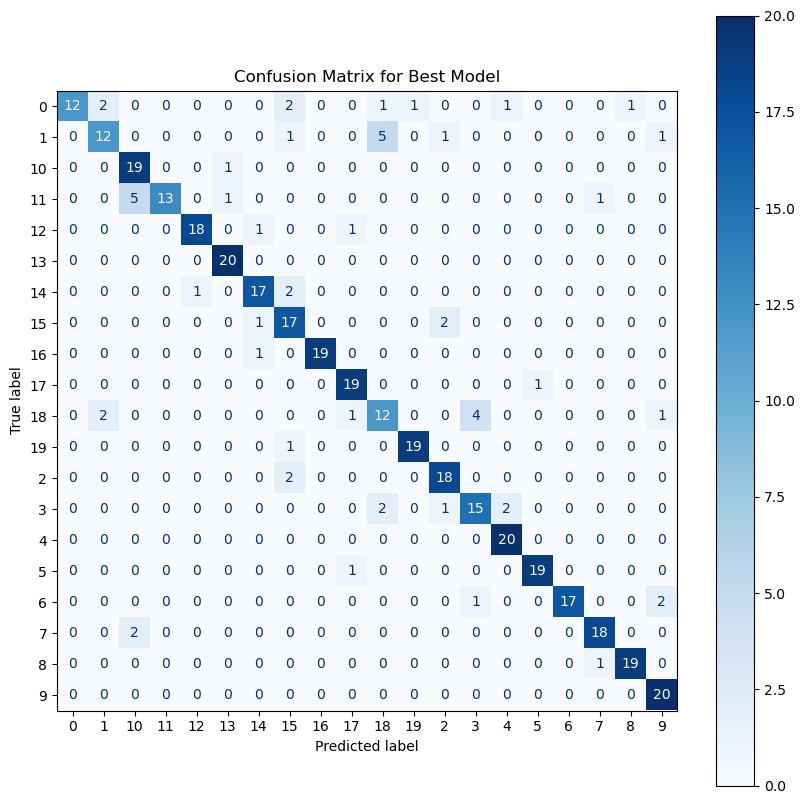

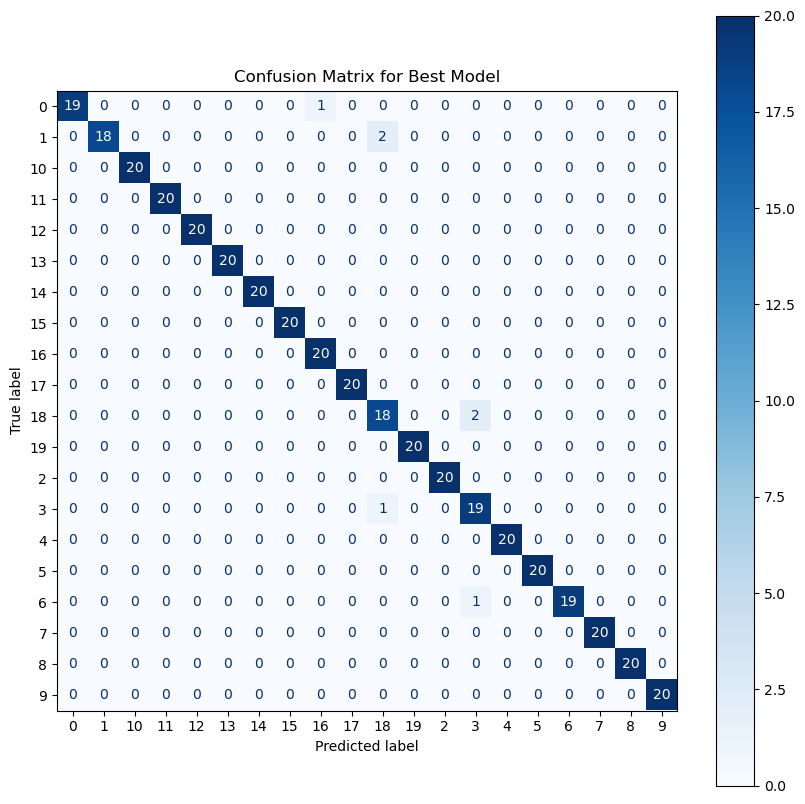

In [49]:
# Run the training
if __name__ == "__main__":
    main()

In [42]:
# Contents of predict.py
# (Imports are already in Cell 1)
# (dataloader_factory functions are in Cell 7)
# (AUGMENTATION_CONFIG is in Cell 2)

def predict(args):
    """Generates predictions and creates a submission file."""
    # Load configuration
    # with open(args.config, "r") as f:
    #     cfg = yaml.safe_load(f)
    global cfg

    # Setup logging and device
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    device = "cuda" if torch.cuda.is_available() else "cpu"
    logging.info(f"Using device: {device}")

    # Get class names from the TRAINING data directory
    train_dir = Path(cfg['data']['train_dir'])
    class_names = datasets.ImageFolder(root=train_dir).classes
    logging.info(f"Loaded class names for mapping: {class_names}")

    # Initialize Model Architecture
    model_name = cfg['model_params']['name']
    logging.info(f"Initializing model architecture: {model_name}")

    # Note: This block is simplified. For full model support,
    # you should use the dynamic model creation logic from your run_cv_pipeline.py
    if model_name == "efficientnet_b0":
        model = models.efficientnet_b0(weights=None)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features=num_ftrs, out_features=len(class_names))
    elif model_name == "resnet18":
        model = models.resnet18(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(class_names))
    else:
        # This will need to be expanded to support your timm models
        raise ValueError(f"Model '{model_name}' is not supported in this script.")

    # Load the trained weights
    model_path = Path(args.model_path)
    # 2. Add weights_only=True for safety
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
    model.eval()
    logging.info(f"Loaded trained model weights from {model_path}")

    # 3. Create the submission DataLoader using the correct function and arguments
    unlabeled_images_path = cfg['data']['test_dir']
    logging.info(f"Loading unlabeled data from: {unlabeled_images_path}")
    # submission_loader = dataloader_factory.create_submission_dataloader(
    submission_loader = create_submission_dataloader(
        images_dir=unlabeled_images_path,
        cfg=AUGMENTATION_CONFIG
    )

    # Generate Predictions
    logging.info("Generating predictions...")
    image_ids = []
    predictions = []
    with torch.inference_mode():
        # 4. Correctly unpack the THREE items from the dataloader
        for images, _, ids in tqdm(submission_loader, desc="Predicting"):
            images = images.to(device)
            outputs = model(images)
            _, preds_indices = torch.max(outputs, 1)
            predicted_labels = [class_names[p] for p in preds_indices.cpu().numpy()]
            image_ids.extend(ids)
            predictions.extend(predicted_labels)

    # Create and Save Submission File
    submission_df = pd.DataFrame({'id': image_ids, 'predict': predictions})
    submission_path = model_path.parent / "submission.csv" # Save in the same run folder
    submission_df.to_csv(submission_path, index=False)
    logging.info(f"Submission file created at: {submission_path}")
    print("\nSubmission file head:")
    print(submission_df.head())

In [50]:
# Manually set arguments, like argparse would
class PredictArgs:
    model_path = "C:\\Users\\gemastik18\\final\\image-classification\\outputs\\efficientnet_b0_20251028_043051\\best_model_finetuned.pth" # <-- !!! SET THIS !!!
    # config = cfg # This isn't read, but good to show

# --- Run this cell to generate submission.csv ---
if not Path(PredictArgs.model_path).exists():
    print(f"Error: Model path not found. Please update 'PredictArgs.model_path' in this cell.")
else:
    predict(PredictArgs)

2025-10-28 04:37:49,520 - INFO - Using device: cuda
2025-10-28 04:37:49,528 - INFO - Loaded class names for mapping: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']
2025-10-28 04:37:49,528 - INFO - Initializing model architecture: efficientnet_b0
2025-10-28 04:37:49,754 - INFO - Loaded trained model weights from C:\Users\gemastik18\final\image-classification\outputs\efficientnet_b0_20251028_043051\best_model_finetuned.pth
2025-10-28 04:37:49,754 - INFO - Loading unlabeled data from: D:/gemastik/data_clean/clean/test
2025-10-28 04:37:49,761 - INFO - Generating predictions...


Predicting:   0%|          | 0/47 [00:00<?, ?it/s]

2025-10-28 04:37:58,629 - INFO - Submission file created at: C:\Users\gemastik18\final\image-classification\outputs\efficientnet_b0_20251028_043051\submission.csv



Submission file head:
                                     id predict
0  003a97d7ca88c5fe85b7b2d812705f10.jpg      15
1  0050374d197dd3cf0c112ca1d871a12f.jpg      18
2  0072b156fd15cc20fe1ad4d33c54902c.jpg       1
3  0085e3a04af015b51b0c6ddf81638ee9.jpg       4
4  008ff2af62e264c4b04799faef6e2a8e.jpg       9


In [45]:
# Contents of explain.py
# (Imports are already in Cell 1)

def explain_prediction(args):
    """
    Generates an XAI attribution map for a single image prediction.
    """
    # 1. Load configuration and setup
    # with open(args.config, "r") as f:
    #     cfg = yaml.safe_load(f)
    global cfg

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # 2. Load the trained model
    model_path = Path(args.model_path)
    model_name = cfg['model_params']['name']
    
    # Get class names from your training directory
    train_dir = Path(cfg['data']['train_dir'])
    class_names = [d.name for d in train_dir.iterdir() if d.is_dir()]
    class_names.sort() # Ensure consistent order
    print(f"Initializing model '{model_name}' for classes: {class_names}")

    # --- Initialize the correct model architecture (same logic as run_cv_pipeline.py) ---
    if model_name in ["efficientnet_b0", "resnet18", "resnet50", "convnext_tiny", "swin_t"]:
        model_func = getattr(models, model_name)
        model = model_func(weights=None)
    elif model_name in ["maxvit_tiny", "cvt_13", "coat_lite_mini", "efficientformerv2_s0", "levit_192"]:
        model = timm.create_model(model_name, pretrained=False, num_classes=len(class_names))
    else:
        raise ValueError(f"Model architecture '{model_name}' not supported.")

    # Adapt the head for the specific model
    if 'efficientnet' in model_name:
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
    elif 'resnet' in model_name:
        model.fc = nn.Linear(model.fc.in_features, len(class_names))
    # Add logic for other models...
    
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.to(device)
    model.eval()
    print(f"Loaded trained model weights from {model_path}")

    # 3. Load and transform the input image
    image_path = Path(args.image_path)
    image_size = cfg['data_params']['image_size']
    
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])
    
    norm_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    img = Image.open(image_path).convert("RGB")
    transformed_img = transform(img)
    input_tensor = norm_transform(transformed_img).unsqueeze(0).to(device)

    # 4. Make a prediction
    output = model(input_tensor)
    output_probs = torch.nn.functional.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output_probs, 1)
    pred_label_name = class_names[pred_label_idx.item()]
    
    print(f"\nPrediction: '{pred_label_name}' with confidence: {prediction_score.item():.4f}")

    # 5. Generate Explanation using Integrated Gradients
    integrated_gradients = IntegratedGradients(model)
    # The target is the index of the predicted class
    attributions = integrated_gradients.attribute(input_tensor, target=pred_label_idx.item())

    # 6. Visualize and Save the Explanation
    # Convert tensor back to a displayable image format
    img_to_display = transformed_img.permute(1, 2, 0).numpy()
    
    # Visualize the attributions
    fig, _ = viz.visualize_image_attr(
        np.transpose(attributions.squeeze().cpu().detach().numpy(), (1, 2, 0)),
        img_to_display,
        method="blended_heat_map",
        sign="absolute_value",
        show_colorbar=True,
        title=f"Attribution for Prediction: {pred_label_name}"
    )
    
    # Save the figure
    save_path = model_path.parent / f"explanation_{image_path.stem}.png"
    fig.savefig(save_path)
    print(f"Explanation saved to: {save_path}")

Using device: cuda
Initializing model 'efficientnet_b0' for classes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']
Loaded trained model weights from C:\Users\gemastik18\final\image-classification\outputs\efficientnet_b0_20251028_041554\best_model_finetuned.pth

Prediction: '4' with confidence: 0.8958


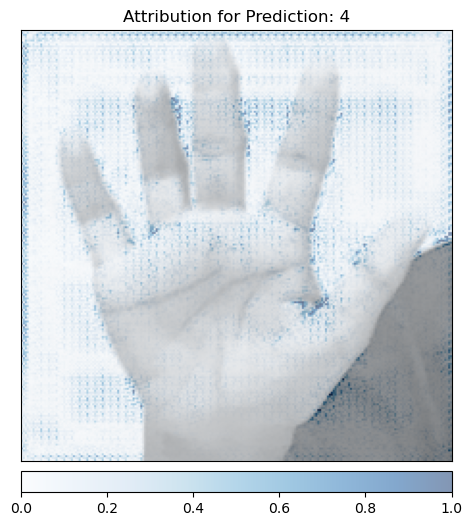

Explanation saved to: C:\Users\gemastik18\final\image-classification\outputs\efficientnet_b0_20251028_041554\explanation_0085e3a04af015b51b0c6ddf81638ee9.png


In [51]:
# Manually set arguments, like argparse would
class ExplainArgs:
    model_path = "C:\\Users\\gemastik18\\final\\image-classification\\outputs\\efficientnet_b0_20251028_041554\\best_model_finetuned.pth" # <-- !!! SET THIS !!!
    image_path = "D:\\gemastik\\data_clean\\clean\\test\\0085e3a04af015b51b0c6ddf81638ee9.jpg" # <-- !!! SET THIS to a sample image !!!
    # config = "config_cv.yaml"

# --- Run this cell to generate an explanation.png ---
if not Path(ExplainArgs.model_path).exists():
    print(f"Error: Model path not found. Please update 'ExplainArgs.model_path' in this cell.")
elif not Path(ExplainArgs.image_path).exists():
    print(f"Error: Image path not found. Please update 'ExplainArgs.image_path' in this cell.")
else:
    explain_prediction(ExplainArgs)